In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch

from helpers.Classifier import *
import os


In [2]:
os.environ["CUDA_VISIBLE_DEVICES"]="3"

# selecting appropriate device
CUDA = torch.cuda.is_available()
print("cuda available:", CUDA)
device = torch.device("cuda" if CUDA else "cpu")

path_to_working_dir = "/global/cfs/cdirs/m3246/rmastand/bkg_extrap/redo/"
static_data_dir = f"{path_to_working_dir}/data/"
eval_dir = f"{path_to_working_dir}/evaluation/"

n_context = 2

cuda available: True


In [3]:
# load in test events
test_events = np.load(f"{static_data_dir}/test_SR.npz")
test_bkg = test_events["bkg_events_SR"][:,n_context:]
test_sig = test_events["sig_events_SR"][:,n_context:]

input_x_test = np.concatenate([test_bkg, test_sig], axis=0)
input_y_test = np.concatenate([np.zeros(test_bkg.shape[0]).reshape(-1,1), np.ones(test_sig.shape[0]).reshape(-1,1)], axis=0)

### Files to load in

In [6]:
keys = ["reweight", "generate", "morph", "ideal", "full_sup"]

n_classifier_runs = 10
signal_injection_seeds = range(1, 2)

sig_inj = [0]#.0075, 0.012, 0.016, 0.02]
significances = [0]#[0, 0.66, 1.34, 2.01, 3.22, 4.29, 5.37]

# initialize dirs
rejections_dict = {k:{s:[] for s in sig_inj} for k in keys}                
sics_dict = {k:{s:[] for s in sig_inj} for k in keys}
rocs_dict = {k:{s:[] for s in sig_inj} for k in keys}
max_sics_dict = {k:{s:[] for s in sig_inj} for k in keys}
sic_at_rej1_dict = {k:{s:[] for s in sig_inj} for k in keys}
sic_at_rej2_dict = {k:{s:[] for s in sig_inj} for k in keys}

auc_dict = {k:{s:[] for s in sig_inj} for k in keys}

rejection1_for_sic = 1000
rejection2_for_sic = 10000

x_axis = np.logspace(-5, 0, 100)
x_axis_roc = np.linspace(0, 1, 100)

### Process

In [10]:
for s in sig_inj:
    
    print(f"Evaluating s/b= {s}...")
    for k in keys:
        for data_seed in signal_injection_seeds:
            scores_to_ensemble = []
            
            # ensemble over runs
            for i in range(n_classifier_runs):
                            
                if k == "full_sup": # Only need to train 1 "seed" for the fullup model
                    model_dir = f"{eval_dir}/seed1/"
                    local_id = f"{k}_run{i}"
                    if data_seed > 1:
                        break
    
                else:
                    model_dir = f"{eval_dir}/seed{data_seed}/"
                    local_id = f"{k}_s{s}_run{i}"
                    
                # load in the model
                model_path = f"{model_dir}/model_{local_id}.pt"
                loc_NN = torch.load(model_path)
                
                scores = loc_NN.evaluation(input_x_test)
                scores_to_ensemble.append(scores)
                
            avg_scores = np.mean(scores_to_ensemble, axis = 0)
            fpr, tpr, _ = roc_curve(input_y_test, avg_scores)
            
            fpr_nonzero_indices = np.where(fpr != 0)
            fpr_nonzero = fpr[fpr_nonzero_indices]
            tpr_nonzero = tpr[fpr_nonzero_indices]
            rejection = 1.0 / fpr_nonzero 
            sic = tpr_nonzero / np.sqrt(fpr_nonzero) 

            # calculate the maxsic
            eps_bkg = 0 # TODO
            fpr_cutoff_indices = np.where(fpr_nonzero > eps_bkg)
            maxsic = np.nanmax(sic[fpr_cutoff_indices])

            # calculate the sic at the desired rejection rejection_for_sic
            for ind in range(len(rejection)):
                if (rejection[ind] >= rejection1_for_sic) and (rejection[ind+1] < rejection1_for_sic):
                    sic_at_rejection1 = sic[ind]
                if (rejection[ind] >= rejection2_for_sic) and (rejection[ind+1] < rejection2_for_sic):
                    sic_at_rejection2 = sic[ind]

            interp_sic = np.interp(x_axis, tpr_nonzero, sic)
            interp_rej = np.interp(x_axis, tpr_nonzero, rejection)
            interp_roc = np.interp(x_axis_roc, fpr, tpr)

            rejections_dict[k][s].append(interp_rej)
            sics_dict[k][s].append(interp_sic)
            rocs_dict[k][s].append(interp_roc)
            
            max_sics_dict[k][s].append(maxsic)
            sic_at_rej1_dict[k][s].append(sic_at_rejection1)
            sic_at_rej2_dict[k][s].append(sic_at_rejection2)

print("Done!")

Evaluating s/b= 0...
Done!


In [13]:
def get_med_percentile(loc_list, lower_p = 16, upper_p = 84):
    
    med = np.nanmedian(loc_list, axis = 0)
    lower_p  = np.nanpercentile(loc_list, lower_p, axis = 0)
    upper_p = np.nanpercentile(loc_list, upper_p, axis = 0)
    
    return med, lower_p, upper_p

In [14]:
# Take medians
med_rejections_dict = {k:{s:[] for s in sig_inj} for k in keys}
med_sics_dict = {k:{s:[] for s in sig_inj} for k in keys}
med_rocs_dict = {k:{s:[] for s in sig_inj} for k in keys}
med_max_sics_dict = {k:[np.array([]),np.array([]),np.array([])] for k in keys} # mean, lower_p, upper_p
med_sics_at_rej1_dict = {k:[np.array([]),np.array([]),np.array([])] for k in keys}
med_sics_at_rej2_dict = {k:[np.array([]),np.array([]),np.array([])] for k in keys}

for s in sig_inj:
    
    for k in keys:

        med_rejections_dict[k][s] = get_med_percentile(rejections_dict[k][s])
        med_sics_dict[k][s] = get_med_percentile(sics_dict[k][s])
        med_rocs_dict[k][s] = get_med_percentile(rocs_dict[k][s])
                 
        # max sic sic at rejection are single numbers, not arrays
        med_max_sics_dict[k][0] = np.append(med_max_sics_dict[k][0], np.median(max_sics_dict[k][s]))
        med_max_sics_dict[k][1] = np.append(med_max_sics_dict[k][1], np.percentile(max_sics_dict[k][s], 16)) 
        med_max_sics_dict[k][2] = np.append(med_max_sics_dict[k][2], np.percentile(max_sics_dict[k][s], 84))        
            
        med_sics_at_rej1_dict[k][0] = np.append(med_sics_at_rej1_dict[k][0], np.median(sic_at_rej1_dict[k][s]))
        med_sics_at_rej1_dict[k][1] = np.append(med_sics_at_rej1_dict[k][1], np.percentile(sic_at_rej1_dict[k][s], 16))
        med_sics_at_rej1_dict[k][2] = np.append(med_sics_at_rej1_dict[k][2], np.percentile(sic_at_rej1_dict[k][s], 84))
        
        med_sics_at_rej2_dict[k][0] = np.append(med_sics_at_rej2_dict[k][0], np.median(sic_at_rej2_dict[k][s]))
        med_sics_at_rej2_dict[k][1] = np.append(med_sics_at_rej2_dict[k][1], np.percentile(sic_at_rej2_dict[k][s], 16))
        med_sics_at_rej2_dict[k][2] = np.append(med_sics_at_rej2_dict[k][2], np.percentile(sic_at_rej2_dict[k][s], 84))
      

## Summary plots

In [15]:
# Plotting params

colors_dict = {"full_sup":"grey",
               "reweight": "forestgreen",
               "morph": "mediumvioletred",
               "generate":"darkgoldenrod",
                "ideal":"darkblue"}


labels_dict = {"full_sup":"Fully Supervised",
               "reweight": "Reweight",
               "morph": "Morph",
               "generate":"Generate",
              "ideal": "Ideal"}


l = 3
f1 = 24
f2 = 16

alpha = 0.4

### Plot max(SIC)

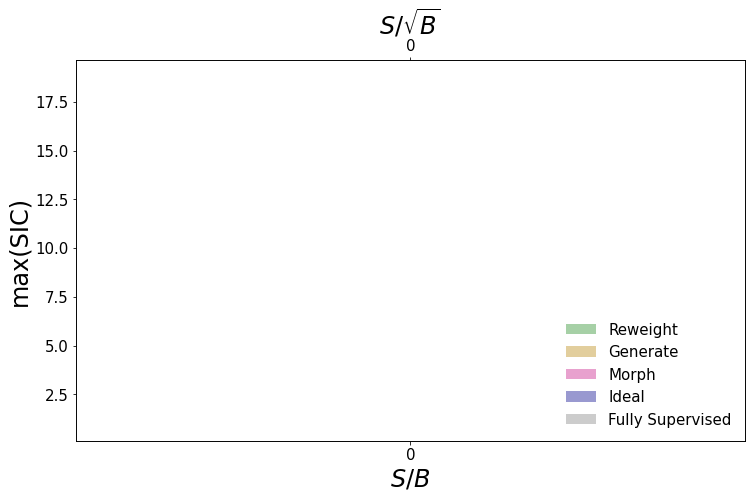

In [19]:
f1 = 24
f2 = 15


fig = plt.figure(figsize = (12, 7)) 
ax1 = fig.add_subplot(111)

for k in keys:  
    ax1.plot(sig_inj, med_max_sics_dict[k][0], color = colors_dict[k])   
    ax1.fill_between(sig_inj, med_max_sics_dict[k][1],
                        med_max_sics_dict[k][2],
                         alpha = alpha,
                     linewidth = 0, label = labels_dict[k], color = colors_dict[k])

ax1.set_xticks(np.array([sig_inj]).reshape(len(sig_inj),))
ax1.set_xlabel("$S/B$", fontsize = f1)
ax1.legend( fontsize = f2, frameon = False, loc = "lower right")
ax1.set_ylabel("max(SIC)", fontsize = f1)
ax1.tick_params(axis='both', which='major', labelsize=f2)

# second axis for significances
ax2 = ax1.twiny() 
ax2.set_xticks(sig_inj, labels = significances, fontsize = f2)
ax2.set_xlim(ax1.get_xlim())
ax2.set_xlabel("$S/\sqrt{B}$", fontsize = f1)

fig.savefig(f"plots/maxsic.pdf")

plt.show()

### Plot SIC at a rejection of 10^3

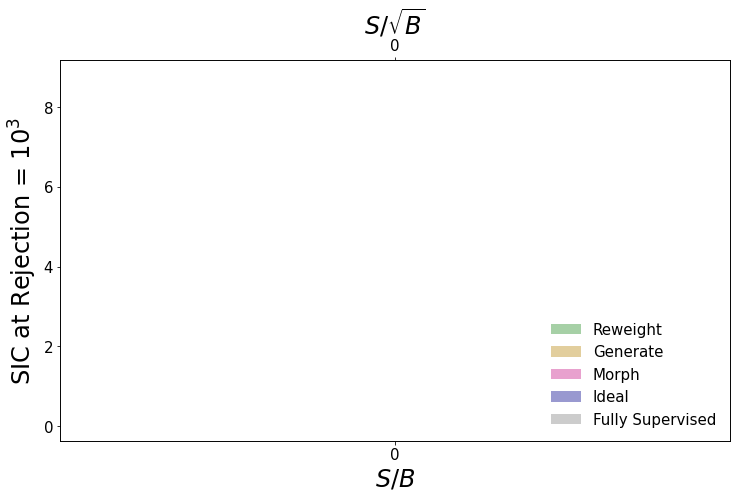

In [21]:

fig = plt.figure(figsize = (12, 7)) 
ax1 = fig.add_subplot(111)

for k in keys:    
   
    ax1.plot(sig_inj, med_sics_at_rej1_dict[k][0], color = colors_dict[k])
    ax1.fill_between(sig_inj, med_sics_at_rej1_dict[k][1],
                        med_sics_at_rej1_dict[k][2],
                         alpha = alpha,
                     linewidth = 0, label = labels_dict[k], color = colors_dict[k])

ax1.set_xticks(np.array([sig_inj]).reshape(len(sig_inj),))
ax1.set_xlabel("$S/B$", fontsize = f1)
ax1.legend( fontsize = f2, frameon = False, loc = "lower right")
ax1.set_ylabel("SIC at Rejection = $10^3$", fontsize = f1)
ax1.tick_params(axis='both', which='major', labelsize=f2)

# second axis for significances
ax2 = ax1.twiny() 
ax2.set_xticks(sig_inj, labels = significances, fontsize = f2)
ax2.set_xlim(ax1.get_xlim())
ax2.set_xlabel("$S/\sqrt{B}$", fontsize = f1)

fig.savefig(f"plots/sic_at_rej_1000.pdf")

plt.show()

### Plot SIC at a rejection of 10^4

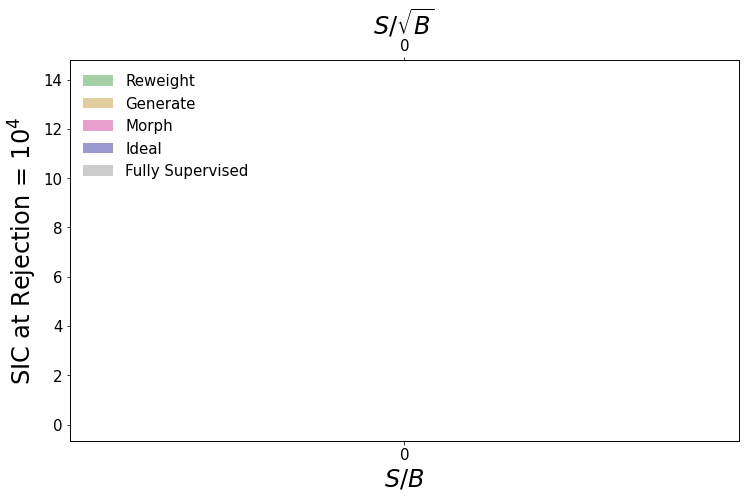

In [23]:

fig = plt.figure(figsize = (12, 7)) 
ax1 = fig.add_subplot(111)

for k in keys:
    
    ax1.plot(sig_inj, med_sics_at_rej2_dict[k][0], color = colors_dict[k])
    ax1.fill_between(sig_inj, med_sics_at_rej2_dict[k][1],
                        med_sics_at_rej2_dict[k][2],
                         alpha = alpha,
                     linewidth = 0, label = labels_dict[k], color = colors_dict[k])

ax1.set_xticks(np.array([sig_inj]).reshape(len(sig_inj),))
ax1.set_xlabel("$S/B$", fontsize = f1)
ax1.legend( fontsize = f2, frameon = False, loc = "upper left")
ax1.set_ylabel("SIC at Rejection = $10^4$", fontsize = f1)
ax1.tick_params(axis='both', which='major', labelsize=f2)

# second axis for significances
ax2 = ax1.twiny() 
ax2.set_xticks(sig_inj, labels = significances, fontsize = f2)
ax2.set_xlim(ax1.get_xlim())
ax2.set_xlabel("$S/\sqrt{B}$", fontsize = f1)

fig.savefig(f"plots/sic_at_rej_10000.pdf")



## Fixed S/B plots

### Plot SIC 

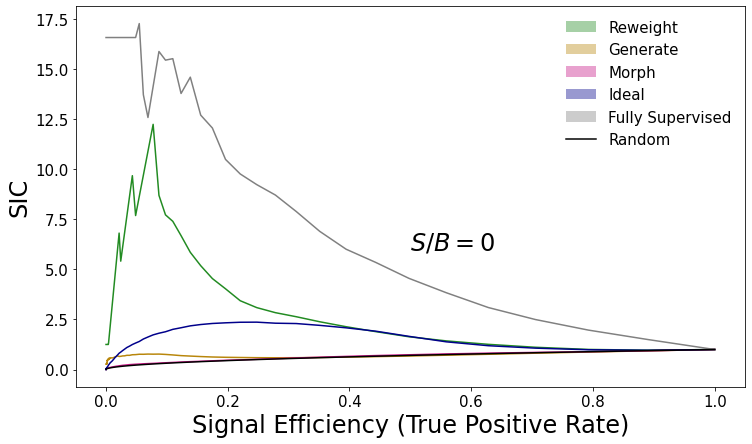

In [25]:
n_to_plot = [0]

for n in n_to_plot:

    fig = plt.figure(figsize = (12, 7))

    for k in keys:
        
        plt.plot(x_axis, med_sics_dict[k][n][0], color = colors_dict[k])
        plt.fill_between(x_axis, med_sics_dict[k][n][1],
                    med_sics_dict[k][n][2], linewidth = 0, label = labels_dict[k], color = colors_dict[k], alpha = alpha)

    plt.plot(x_axis, x_axis/np.sqrt(x_axis), label = "Random", color = "black",)
        

    plt.text(0.5, 6, f"$S/B = {np.round(n, 4)}$", fontsize = f1)
    plt.legend( fontsize = f2, frameon = False)
    plt.xlabel("Signal Efficiency (True Positive Rate)", fontsize = f1)    
    plt.ylabel("SIC", fontsize = f1)
    plt.tick_params(axis='both', which='major', labelsize=f2)
        
    plt.show()

### Plot SIC vs rejection

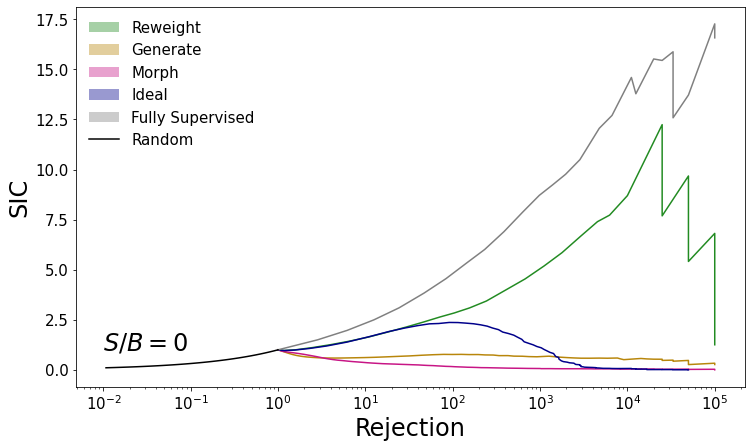

In [26]:
for n in n_to_plot:

    fig = plt.figure(figsize = (12, 7))

    for k in keys:
        plt.plot(med_rejections_dict[k][n][0], med_sics_dict[k][n][0], color = colors_dict[k])

        plt.fill_between(med_rejections_dict[k][n][0], med_sics_dict[k][n][1],
                    med_sics_dict[k][n][2], linewidth = 0, label = labels_dict[k], color = colors_dict[k], alpha = alpha)
  

    plt.plot(x_axis[60:], x_axis[60:]/np.sqrt(x_axis[60:]), label = "Random", color = "black",)
    
    plt.xscale("log")    
    plt.text(0.01, 1, f"$S/B = {np.round(n, 4)}$", fontsize = f1)
    plt.legend( fontsize = f2, frameon = False,)
    plt.xlabel("Rejection", fontsize = f1)
    plt.ylabel("SIC", fontsize = f1)
    plt.tick_params(axis='both', which='major', labelsize = f2)
        
    plt.show()

### Plot ROCs

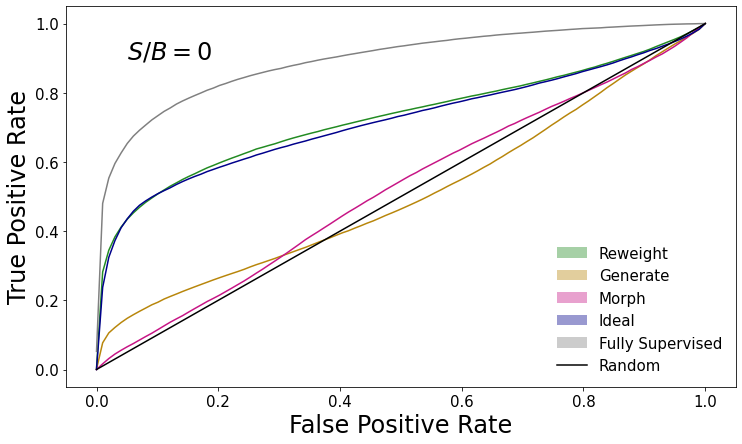

In [27]:
n_to_plot = [0]

for n in n_to_plot:

    fig = plt.figure(figsize = (12, 7))

    for k in keys:

        plt.plot(x_axis_roc, med_rocs_dict[k][n][0], color = colors_dict[k])

        plt.fill_between(x_axis_roc, med_rocs_dict[k][n][1],
                    med_rocs_dict[k][n][2], linewidth = 0, label = labels_dict[k], color = colors_dict[k], alpha = alpha)
  

    plt.plot(x_axis_roc, x_axis_roc, label = "Random", color = "black",)

    plt.text(0.05, 0.9, f"$S/B = {np.round(n, 4)}$", fontsize = f1)
    plt.legend( fontsize = f2, frameon = False)
    plt.xlabel("False Positive Rate", fontsize = f1)    
    plt.ylabel("True Positive Rate", fontsize = f1)
    plt.tick_params(axis='both', which='major', labelsize=f2)
    plt.show()